In [3]:
import random
import gym
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [4]:
EPOCHS = 500
THRESHOLD = 45

In [5]:
class DQN():
    def __init__(self, env_string,batch_size=64):
        self.memory = deque(maxlen=100000)
        self.env = gym.make(env_string)
        input_size = self.env.observation_space.shape[0]
        action_size = self.env.action_space.n
        self.batch_size = batch_size
        self.gamma = 1.0
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        
        alpha=0.01
        alpha_decay=0.01
        
        # Init model
        self.model = Sequential()
        self.model.add(Dense(24, input_dim=input_size, activation='tanh'))
        self.model.add(Dense(48, activation='tanh'))
        self.model.add(Dense(action_size, activation='linear'))
        self.model.compile(loss='mse', optimizer=Adam(learning_rate=alpha))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, epsilon):
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.model.predict(state, verbose=0))

    def preprocess_state(self, state):
        return np.reshape(state, [1, 4])

    def replay(self, batch_size):
        x_batch, y_batch = [], []
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            y_target = self.model.predict(state, verbose=0)
            y_target[0][action] = reward if done else reward + self.gamma * np.max(self.model.predict(next_state, verbose=0)[0])
            x_batch.append(state[0])
            y_batch.append(y_target[0])
        
        self.model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)
        #epsilon = max(epsilon_min, epsilon_decay*epsilon) # decrease epsilon
       

    def train(self):
        scores = deque(maxlen=100)
        avg_scores = []
        

        for e in range(EPOCHS):
            state = self.env.reset()
            if e % 10 == 0:
                self.env.render()
            state = self.preprocess_state(state)
            done = False
            i = 0
            while not done:
                action = self.choose_action(state,self.epsilon)
                next_state, reward, done, _ = self.env.step(action)
                if e % 10 == 0:
                    self.env.render()
                next_state = self.preprocess_state(next_state)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                self.epsilon = max(self.epsilon_min, self.epsilon_decay*self.epsilon) # decrease epsilon
                i += 1
                
            if e % 10 == 0:
                self.env.close()

            scores.append(i)
            mean_score = np.mean(scores)
            avg_scores.append(mean_score)
            print(f'Epoch number {e}')
            if mean_score >= THRESHOLD and e >= 10:
                print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 10))
                return avg_scores
            if e % 10 == 0:
                print('[Episode {}] - Mean survival time over last 10 episodes was {} ticks.'.format(e, mean_score))

            self.replay(self.batch_size)
        
        print('Did not solve after {} episodes 😞'.format(e))
        return avg_scores



In [6]:
env_string = 'CartPole-v0'
agent = DQN(env_string)
scores = agent.train()


Epoch number 0
[Episode 0] - Mean survival time over last 10 episodes was 12.0 ticks.

Epoch number 1
Epoch number 2
Epoch number 3
Epoch number 4
Epoch number 5
Epoch number 6
Epoch number 7
Epoch number 8
Epoch number 9
Epoch number 10
[Episode 10] - Mean survival time over last 10 episodes was 16.818181818181817 ticks.
Epoch number 11
Epoch number 12
Epoch number 13
Epoch number 14
Epoch number 15
Epoch number 16
Epoch number 17
Epoch number 18
Epoch number 19
Epoch number 20
[Episode 20] - Mean survival time over last 10 episodes was 14.380952380952381 ticks.
Epoch number 21
Epoch number 22
Epoch number 23
Epoch number 24
Epoch number 25
Epoch number 26
Epoch number 27
Epoch number 28
Epoch number 29
Epoch number 30
[Episode 30] - Mean survival time over last 10 episodes was 13.03225806451613 ticks.
Epoch number 31
Epoch number 32
Epoch number 33
Epoch number 34
Epoch number 35
Epoch number 36
Epoch number 37
Epoch number 38
Epoch number 39
Epoch number 40
[Episode 40] - Mean surv

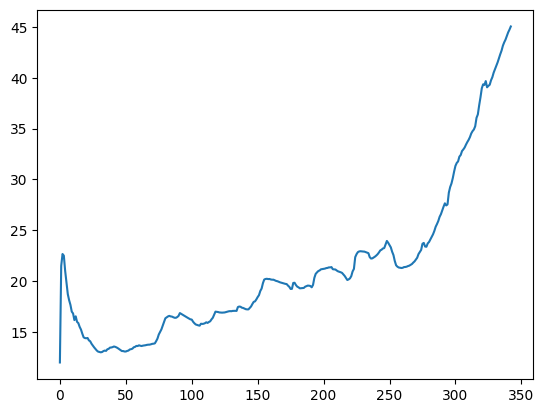

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                120       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 2)                 98        
                                                                 
Total params: 1418 (5.54 KB)
Trainable params: 1418 (5.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
plt.plot(scores)
plt.show()
agent.model.summary()
agent.env.close()